In [98]:
# Modules for loading, plotting and manipulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Modules for modelling and evaluation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,log_loss

## Load Data

In [2]:
# Load train data
train = pd.read_csv('train_set.csv')
# load test data
test = pd.read_csv('test_set.csv')
# load sample submission
sample_sub = pd.read_csv('sample_submission.csv')

In [3]:
# View first five rows of the train data
train.head()

lang_id                                               text
0     xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1     xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2     eng  the province of kwazulu-natal department of tr...
3     nso  o netefatša gore o ba file dilo ka moka tše le...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

In [68]:
train.shape

(33000, 2)

In [4]:
#view first rows of the test data
test.head()

index                                               text
0      1  Mmasepala, fa maemo a a kgethegileng a letlele...
1      2  Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2      3         Tshivhumbeo tshi fana na ngano dza vhathu.
3      4  Kube inja nelikati betingevakala kutsi titsini...
4      5                      Winste op buitelandse valuta.

In [66]:
# view head rows of sample submission
sample_sub.head()

index lang_id
0      1     tsn
1      2     nbl

## Exploratory Data Analysis

In [6]:
# view the distribution of languages in the data
train.lang_id.value_counts()

eng    3000
nbl    3000
tso    3000
ssw    3000
afr    3000
nso    3000
zul    3000
tsn    3000
ven    3000
xho    3000
sot    3000
Name: lang_id, dtype: int64

In [67]:
print('The Dataset has {} Unique language Values'.format(train.lang_id.nunique()))

The Dataset has 11 Unique language Values


**The Data set has 33,000 rows and two columns, it also has 11 unique language values, spread evenly at 3000 each for each class**

**Next we would do a wordcloud plot to see the occurece of words in each class**

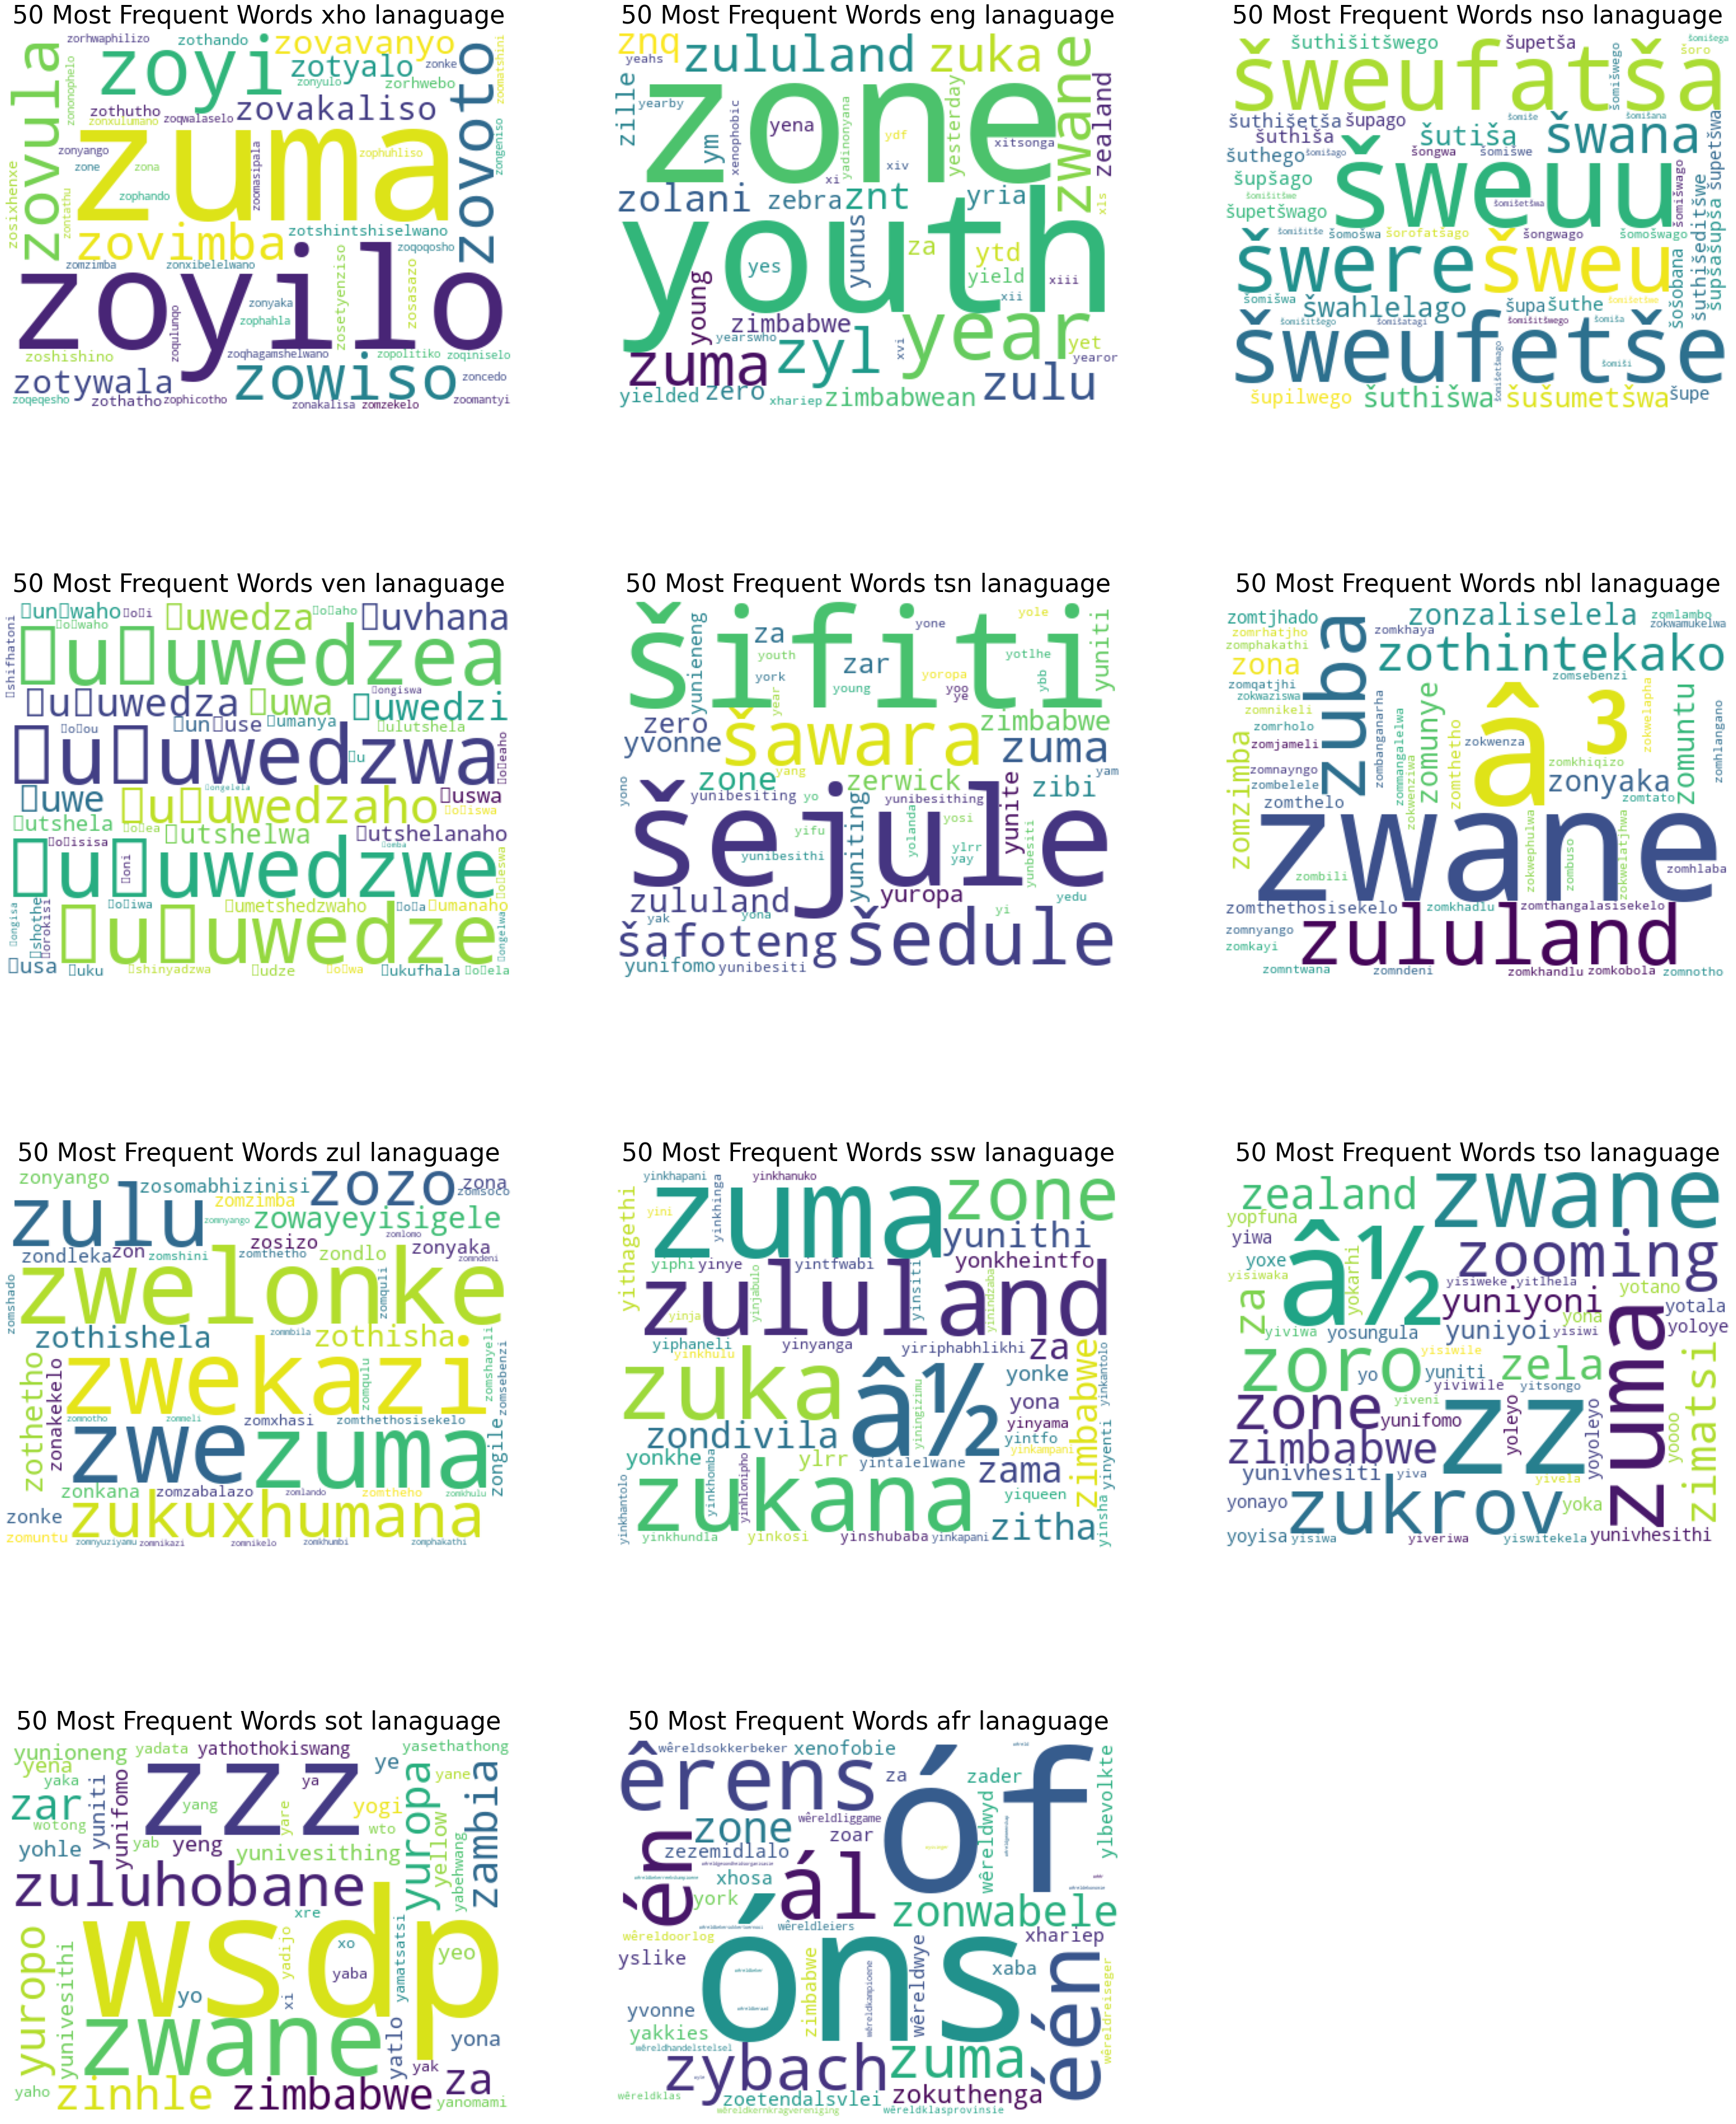

In [51]:
def word_cloud(data, lang_id, amount):
    # Create a variable to store the text
    data = data[data['lang_id'] == lang_id]
    cv = CountVectorizer()
    cv_data = cv.fit_transform(data.text)
    dict_ = {k:v for k,v in sorted(cv.vocabulary_.items(),key = lambda item: item[1],reverse =True)}
    word_list = [word for word in dict_.keys()][:amount]
    text = " ".join(word for word in word_list)
    # Instantiate wordcloud object
    word_cloud = WordCloud(collocations =False,
                          background_color = 'White',
                          width=400, 
                          height=300, 
                          contour_width=2, 
                          contour_color='steelblue')
    # generate wordcloud images
    return word_cloud.generate(text)


# Create Plot
size = train.lang_id.nunique()
amount = 50  #Change this number to reduce or increase the amount of words plotted 
plot = list(train.lang_id.unique())
fig = plt.figure(figsize=(50, 50 * size // 3))
for index, column in enumerate(plot):
    ax = fig.add_subplot(size, 3, index + 1)
    wordcloud = word_cloud(train, column, amount)
    ax.imshow(wordcloud)
    plt.title('{} Most Frequent Words {} lanaguage'.format(amount,column), size = 40, pad =15)
    ax.axis('off')


**From the plots we can see that the words in each language are quite unique and rarely overlap with the others(in terms of frequency) Due to this fact we would not be applying removal of stop words. Also, the words are not english words, hence we would not be lemmatizing or cleaning the data any further, as cleaning might end up removing some of the important informations from the data.**

## Model


**Before we fit this data to any model, we must first transform the target column( language_id) from text format into numbers, this can be done via sklearn's LabelEncoder**

In [106]:
#Instantiate the label encoder class
le = LabelEncoder()
# fit the label encodel object to the language_id column
le.fit(train['lang_id'])
# transform the language_id column
train['lang_id'] = le.transform(train['lang_id'])

In [107]:
# View the first five columns of the transformed dataset
train.head()

lang_id                                               text
0        9  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1        9  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2        1  the province of kwazulu-natal department of tr...
3        3  o netefatša gore o ba file dilo ka moka tše le...
4        8  khomishini ya ndinganyiso ya mbeu yo ewa maana...

In [108]:
# Next we split our data into train and test set, so we can use the test set to evaluate models performance
# i would set the test_size as 20% i.e 80% for training
x_train, x_test, y_train, y_test = train_test_split(train.text, train.lang_id, test_size = 0.2, random_state =28)

# view the Distribution of values in the train and test language_id feature
print("The train language_id are", y_train.value_counts())
print(' ')
print("The test language_id are", y_test.value_counts())

The train language_id are 0     2440
5     2423
6     2408
4     2399
7     2398
8     2398
9     2397
2     2394
1     2384
3     2380
10    2379
Name: lang_id, dtype: int64
 
The test language_id are 10    621
3     620
1     616
2     606
9     603
8     602
7     602
4     601
6     592
5     577
0     560
Name: lang_id, dtype: int64


**for the modelling Phase, we would try out 5 models on the same training set, as the model with the best performance would be chosen. I would use sklearns, pipeline module to fit the bag of words model and each classification model in one command. This would help reduce the amount of code to  be written and also reduce the amount of time we call the fit method on the data**

In [109]:
# Instantiate a count vectorizer object to be used for all the classification models
# max_df of 7500, implies do not count words that appear more that 7500 in the corpus
cv = CountVectorizer(ngram_range=(1, 1), max_df = 7500)  

## Random Forest

In [110]:
# Create objects of RandomForest
rf = RandomForestClassifier(n_estimators = 200, random_state = 28)
forest = Pipeline([('vectorizer', cv), ('rf',rf)])
# fit The pipeline
forest.fit(x_train, y_train)

print("Training f1_score: {}".format(f1_score(forest.predict(x_train), y_train,average = 'weighted')))

Training f1_score: 1.0


In [111]:
# Evaluate the model on the test set
f1score = f1_score(y_test, forest.predict(x_test), average ='weighted')
precision = precision_score(y_test, forest.predict(x_test), average ='weighted')
recall = recall_score(y_test, forest.predict(x_test), average ='weighted')
y_hat = forest.predict_proba(x_test)
f_loss = log_loss(y_test, y_hat)
print("the f1score for Random Forest is: {}".format(f1score))
print("the precission for Random Forest is: {}".format(precision))
print("the recall for Random Forest is: {}".format(recall))
print("The log loss error for Random Forest is: {}".format(log_loss(y_test, y_hat)))

the f1score for Random Forest is: 0.9880511168276108
the precission for Random Forest is: 0.9882227359136436
the recall for Random Forest is: 0.988030303030303
The log loss error for Random Forest is: 0.15440702717002563


## Logistic regression

In [112]:
# Create objects of LogisticRegression model
lr = LogisticRegression(multi_class = 'ovr',  max_iter=5000, C = 5 , random_state = 28)
logistic = Pipeline([('vectorizer', cv), ('logistic_regression',lr)])

# fit The pipeline
logistic.fit(x_train, y_train)

print("Training f1_score: {}".format(f1_score(logistic.predict(x_train), y_train,average = 'weighted')))

Training f1_score: 1.0


In [113]:
# Evaluate the model on the test set
f1score = f1_score(y_test, logistic.predict(x_test), average ='weighted')
precision = precision_score(y_test, logistic.predict(x_test), average ='weighted')
recall = recall_score(y_test, logistic.predict(x_test), average ='weighted')
y_hat = logistic.predict_proba(x_test)
l_loss = log_loss(y_test, y_hat)
print("the f1score of the Logistic regression is: {}".format(f1score))
print("the precission of the Logistic regression is: {}".format(precision))
print("the recall of the Logistic regression is: {}".format(recall))
print("The log loss error of the Logistic regression is: {}".format(log_loss(y_test, y_hat)))

the f1score of the Logistic regression is: 0.9962129391521584
the precission of the Logistic regression is: 0.9962152339448879
the recall of the Logistic regression is: 0.9962121212121212
The log loss error of the Logistic regression is: 0.020474249955020528


## K Nearest Neigbours

In [114]:
n = 10 # number of neigbours to consider

# Instantiate KNN object
knn = KNeighborsClassifier(n)

neigbour = Pipeline([('vectorizer', cv), ('K Nearest Neigbour',knn)])

# fit The pipeline
neigbour.fit(x_train, y_train)

print("Training f1_score: {}".format(f1_score(neigbour.predict(x_train), y_train,average = 'weighted')))

Training f1_score: 0.9495798923546782


In [115]:
# Evaluate the model on the test set
f1score = f1_score(y_test, neigbour.predict(x_test), average ='weighted')
precision = precision_score(y_test, neigbour.predict(x_test), average ='weighted')
recall = recall_score(y_test, neigbour.predict(x_test), average ='weighted')
y_hat = neigbour.predict_proba(x_test)
k_loss = log_loss(y_test, y_hat)
print("the f1score of the KNN is: {}".format(f1score))
print("the precission of the KNN is: {}".format(precision))
print("the recall of the KNN is: {}".format(recall))
print("The log loss error of the KNN is: {}".format(log_loss(y_test, y_hat)))

the f1score of the KNN is: 0.9229618339104924
the precission of the KNN is: 0.9301230662142295
the recall of the KNN is: 0.921969696969697
The log loss error of the KNN is: 0.3307890392597987


## Support Vector Machine Classifier

In [116]:
# Instantiate SVC class object
svc = SVC(C = 0.5, probability = True) # we set probability = True so we can calculate the predict proba and hence the log_loss

support = Pipeline([('vectorizer', cv), ('Support vector',svc)])

# fit The pipeline
support.fit(x_train, y_train)

print("Training f1_score: {}".format(f1_score(support.predict(x_train), y_train,average = 'weighted')))

Training f1_score: 0.9987114281248839


In [117]:
# Evaluate the model on the test set
f1score = f1_score(y_test, support.predict(x_test), average ='weighted')
precision = precision_score(y_test, support.predict(x_test), average ='weighted')
recall = recall_score(y_test, support.predict(x_test), average ='weighted')
y_hat = support.predict_proba(x_test)
s_loss = log_loss(y_test, y_hat)
print("the f1score of the Support Vector is: {}".format(f1score))
print("the precission of the Support Vector is: {}".format(precision))
print("the recall of the Support Vector is: {}".format(recall))
print("The log loss error of the Support Vector is: {}".format(log_loss(y_test, y_hat)))

the f1score of the Support Vector is: 0.9919726132122157
the precission of the Support Vector is: 0.9919795147405326
the recall of the Support Vector is: 0.991969696969697
The log loss error of the Support Vector is: 0.029910204558826405


## Multinomial Naive Bayes Model

In [118]:
# Create objects of NaiveBayes
nb = MultinomialNB(alpha = 0.3)

bayes = Pipeline([('vectorizer', cv), ('nb',nb)])
# fit The pipeline
bayes.fit(x_train, y_train)

print("Training f1_score: {}".format(f1_score(bayes.predict(x_train), y_train,average = 'weighted')))

Training f1_score: 0.9999621212221393


In [119]:
# Evaluate the model on the test set
f1score = f1_score(y_test, bayes.predict(x_test), average ='weighted')
precision = precision_score(y_test, bayes.predict(x_test), average ='weighted')
recall = recall_score(y_test, bayes.predict(x_test), average ='weighted')
y_hat = bayes.predict_proba(x_test)
b_loss = log_loss(y_test, y_hat)

print("the f1score of the Naive Bayes is: {}".format(f1score))
print("the precission of the Naive Bayes is: {}".format(precision))
print("the recall of the Naive Bayes is: {}".format(recall))
print("The log loss error of the Naive Bayes is: {}".format(log_loss(y_test, y_hat)))

the f1score of the Naive Bayes is: 0.9993936823822276
the precission of the Naive Bayes is: 0.9993949277811366
the recall of the Naive Bayes is: 0.9993939393939394
The log loss error of the Naive Bayes is: 0.006374474183874919


## Selecting a Model

**Clearly we could see that all the models did a decent job on the test set of the data for precision, recall and f1-score. but also i would be considering the log_loss error metric, as this metric penalizes terms that were misclassified with a high probability. i.e if a given text is in language 'xho' and the model predicts 'eng' with a probability of about 0.8, that predicted term would be penalized more compared to another misclassified class of probability 0.2. With this in mind, we want the model that has the lowest log_loss score on the test data. and looking at the results form the five models, the Niave Bayes model has the lowest log_loss score and hence is selected as the optimal model.**

<AxesSubplot:xlabel='models'>

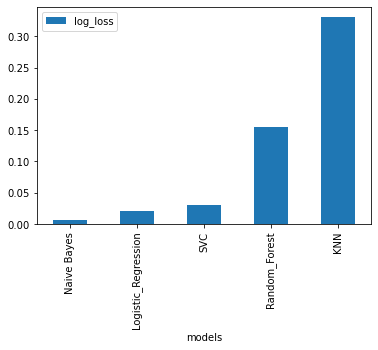

In [120]:
log_loss_  = {'models': ['Random_Forest','Logistic_Regression',
                        'KNN','SVC','Naive Bayes'],
             'log_loss': [f_loss, l_loss, k_loss,
                          s_loss, b_loss]}
loss = pd.DataFrame(log_loss_).set_index('models').sort_values(by = 'log_loss')
loss.plot(kind = 'bar')

# Submission

In [121]:
# Select index column from test data
submission = test.copy()[['index']]

In [122]:
# Assign predictions to submission dataframe
submission['lang_id'] = bayes.predict(test.text)
submission.head()

index  lang_id
0      1        6
1      2        2
2      3        8
3      4        5
4      5        0

**The Values predicted would be in numerical form, we would have to do an inverse transform of the predictions using the label encoder object, so we can get the language_id mappings of each number**

In [61]:
# Invers transform the submission
submission['lang_id'] = le.inverse_transform(submission['lang_id'])
submission.head()

index lang_id
0      1     tsn
1      2     nbl
2      3     ven
3      4     ssw
4      5     afr

In [62]:
# Check the distribution of languages in the predicted value
submission.lang_id.value_counts()

nso    779
afr    739
ven    676
xho    657
tsn    608
sot    541
tso    439
ssw    358
zul    349
nbl    301
eng    235
Name: lang_id, dtype: int64

In [63]:
# Save the file to a csv for upload to kaggle
submission.to_csv('Exam_Naive_Bayes5.csv', index = False)